In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from modules.kidera import score_positions, score_sequence

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import roc_curve, auc, classification_report

from joblib import dump, load

import warnings
warnings.filterwarnings('ignore')

In [2]:
idf1 = pd.read_csv('data/immunogenic_peptides.csv')
idf2 = pd.read_csv('data/immunogenic_peptides.txt', sep='\t')
idf2 = idf2[idf2['Species']=='Homo']

idf1 = idf1.drop(['Epitope Start', 'Epitope End', ' Epitope Source Organism Name', 'Length'], axis=1)
idf1.columns = ['Peptide', 'MHC', 'Immunogenicity']

# idf2["Species"] = idf2.Peptide.str.len()
idf2 = idf2.drop('Species', axis=1)
idf2.columns = ['Peptide', 'MHC', 'Immunogenicity']

idf1 = idf1.reset_index(drop=True)
idf2 = idf2.reset_index(drop=True)
idf = pd.concat([idf1, idf2], axis=0)
idf.Immunogenicity = idf.Immunogenicity.map({'immunogenic': 1, 'non-immunogenic': 0,
                                             'Positive': 1, 'Negative': 0})
idf1 = idf.Peptide.apply(lambda s: score_sequence(s))
idf = pd.concat([idf, idf1], axis=1)
features = ["helix.bend.pref", "side.chain.size",\
        "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",\
        "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]
idf.head()

,Peptide,MHC,Immunogenicity,1,2,3,4,5,6,7,8,9,10
0,KLEDLERDL,HLA-A*02:01,1,-4.98,2.03,-5.96,4.23,-6.27,-6.21,1.99,-1.05,1.92,5.48
1,DLMGYIPLV,HLA-A*02:01,1,0.53,-1.72,0.77,-4.76,0.92,-4.45,0.07,0.72,-0.38,2.41
2,QTVTSTPVQGR,HLA-A*68:01,1,2.91,-5.14,8.00,4.67,1.97,-0.34,0.91,-6.23,-4.32,-1.91
3,TTVYPPSSTAK,HLA-A*03:01,1,5.26,-5.00,3.29,1.70,2.15,-5.02,-2.89,-9.42,-2.92,0.85
4,LITGRLQSL,HLA-A2,1,-1.57,-2.39,3.65,-0.21,-3.00,-5.40,3.48,-2.81,-0.98,0.03


In [3]:
X = idf[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]].values
y = idf['Immunogenicity'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [4]:
rf = RandomForestClassifier(n_estimators=400, min_samples_split=2,
                            min_samples_leaf=1, max_depth=None, bootstrap=False, n_jobs=-1)
ef = ExtraTreesClassifier(n_estimators=1000, max_depth=50, max_features='auto', min_samples_split=2,
                            min_samples_leaf=1, bootstrap=False, n_jobs=-1)
clfs = [
    rf,
    ef
]

cv = StratifiedKFold(n_splits=10)

for clf in clfs:
    print(type(clf).__name__, np.mean(cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)))

RandomForestClassifier 0.826833592661
ExtraTreesClassifier 0.834445386491


In [5]:
rf

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
from sklearn.model_selection import validation_curve

def plt_validation_curve(clf, pname, prange):
    
    train_scores, test_scores = validation_curve(
        clf, X, y, param_name=pname, param_range=prange,
        cv=5, scoring="accuracy", n_jobs=-1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve")
    plt.xlabel(pname)
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(prange, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(prange, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    plt.plot(prange, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(prange, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    plt.show()

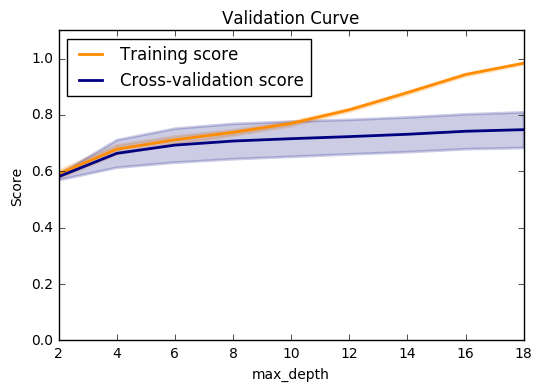

In [7]:
plt_validation_curve(ef, 'max_depth', np.arange(2, 20, 2))

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [9]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_, rf_random.best_score_

({'bootstrap': True,
  'max_depth': 20,
  'max_features': 'sqrt',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 1200},
 0.74321099875014207)

In [10]:
ef_random = RandomizedSearchCV(estimator = ef, param_distributions = random_grid,
                               n_iter = 100, cv = 3, verbose=0, random_state=42, n_jobs = -1)

# Fit the random search model
ef_random.fit(X_train, y_train)

ef_random.best_params_, ef_random.best_score_

({'bootstrap': False,
  'max_depth': 40,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 1400},
 0.75025565276673101)

In [11]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Non-immunogenic', 'Immunogenic']))

                 precision    recall  f1-score   support

Non-immunogenic       0.71      0.71      0.71       972
    Immunogenic       0.77      0.77      0.77      1229

    avg / total       0.74      0.74      0.74      2201



In [15]:
ef.fit(X_train, y_train)
y_pred = ef_random.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Non-immunogenic', 'Immunogenic']))

                 precision    recall  f1-score   support

Non-immunogenic       0.71      0.71      0.71       972
    Immunogenic       0.77      0.77      0.77      1229

    avg / total       0.74      0.74      0.74      2201



In [19]:
dump(rf, 'output/imm_prediction_model.joblib') 

['output/imm_prediction_model.joblib']